---
# 🚗 Car Price Prediction
---

This project demonstrates a complete data-driven workflow for predicting used car prices using web scraping, data preprocessing, linear regression modeling and RandomForestRegressor.

We collect data from the car listings site mashina.kg, clean it, encode categorical features, and train a model to estimate car prices based on various characteristics.


#### 1. Scrape Data from Web
Extract data from the provided website for a specific car model. The following features must be collected for each ad:

- `Car model`

- `Year of production`

- `Engine volume`

- `Mileage`

- `Fuel type`

- `Gearbox mechanism`

- `Steering wheel location` (left/right)

- `Color`

- `Body type` (e.g. sedan, SUV, wagon)

- `Location` (city)

- `Price in USD`

Source: `https://www.mashina.kg/`

#### 2. Prepare data for modelling

- Convert numeric fields to appropriate types (int or float)

- Handle missing values (e.g. by using mean, mode, or regression-based filling)

- Encode categorical variables using:

- Binary encoding (e.g. steering wheel left: 0, right: 1)

- One-hot encoding (for features with more than 2 categories)

#### 3. Train a Price Prediction Model

Define `X` = all features except price

Define `y` = target variable = price in USD

Train a Linear Regression model and RandomForestRegressor

Output the model's score and interpret the learned coefficients

In [1]:
import pandas as pd
import requests
from sklearn.linear_model import LinearRegression
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [2]:
# Initialize storage lists
car_models = []
year_of_productions = []
engine_volumes = []
mileages = []
fuels = []
gearbox_mechanisms = []
steering_wheel_locations = []
colors = []
body_types = []
locations = []
prices_in_USD = []

In [3]:
# Loop through multiple pages
for i in range(1, 33):
    req = requests.get(f"https://www.mashina.kg/search/toyota/?currency=2&price_from=&price_to=&page={i}")
    
    html = req.text
    soup = BeautifulSoup(html)
    soup_pretty = soup.prettify()
    
    cars_all = soup.find_all('div', class_='list-item list-label')

    for car in cars_all:
        # Extract basic details
        car_model = car.find('h2', class_='name').text.strip()
        year_of_production = car.find('p', class_='year-miles').text.split()[0]

        # Extract and convert engine volume
        try:
            engine_volume = car.find('p', class_='year-miles').text.split()[2]
            engine_volume = float(engine_volume)
        except:
            engine_volume = None

        # Extract gearbox
        gearbox = car.find('p', class_='year-miles').text.split()[-1]

        # Extract and convert mileage
        try:
            mileage = car.find('p', class_='volume').text.replace('\n', '').split()[2]
            mileage = float(mileage)
        except:
            mileage = None

        # Other attributes
        steering_wheel_location = car.find('p', class_='volume').text.split()[1].replace(',', '')
        color = car.find('i')['title']
        fuel = car.find('p', class_='body-type').text.strip().split()[-1]
        body_type = car.find('p', class_='body-type').text.strip().split()[0].replace(',', '')
        location = car.find('p', class_='city').text.split()[0]

        # Price in USD
        price_in_USD = car.find('div', class_='block price').find('strong').text.split()
        price2 = ''
        for j in range(1, len(price_in_USD)):
            price2 += price_in_USD[j]

        # Append all values
        car_models.append(car_model)
        year_of_productions.append(float(year_of_production))
        engine_volumes.append(engine_volume)
        mileages.append(mileage)
        fuels.append(fuel)
        colors.append(color)
        gearbox_mechanisms.append(gearbox)
        steering_wheel_locations.append(steering_wheel_location)
        body_types.append(body_type)
        locations.append(location)
        prices_in_USD.append(float(price2))

In [4]:
# Assemble the data into a DataFrame
df = pd.DataFrame({
    'Car model': car_models,
    'Year of production': year_of_productions,
    'Engine volume': engine_volumes,
    'Mileage': mileages,
    'Fuel': fuels,
    'Gearbox mechanism': gearbox_mechanisms,
    'Steering wheel location': steering_wheel_locations,
    'Color': colors,
    'Body type': body_types,
    'Location': locations,
    'Price in USD': prices_in_USD
})

In [5]:
df.head()

,Car model,Year of production,Engine volume,Mileage,Fuel,Gearbox mechanism,Steering wheel location,Color,Body type,Location,Price in USD
0,Toyota RAV4,2017.0,2.5,180.0,бензин,автомат,слева,белый,внедорожник,Бишкек,18500.0
1,Toyota RAV4,2021.0,2.5,95.0,гибрид,автомат,слева,белый,внедорожник,Бишкек,35000.0
2,Toyota Camry,2022.0,2.0,4.0,бензин,вариатор,слева,белый,седан,Бишкек,27000.0
3,Toyota C-HR,2023.0,2.0,7.0,бензин,вариатор,слева,белый,внедорожник,Бишкек,23750.0
4,Toyota Camry,2021.0,2.5,105.0,бензин,автомат,слева,белый,седан,Джалал-Абад,20500.0


In [6]:
# Display summary statistics for numeric features
df.describe()

,Year of production,Engine volume,Mileage,Price in USD
count,640.000000,638.000000,634.000000,640.000000
mean,2014.825000,2.573668,139.853312,22743.020313
std,7.922789,0.808372,102.642998,16802.972862
min,1989.000000,1.000000,1.000000,685.000000
25%,2007.000000,2.000000,50.000000,11500.000000
50%,2018.000000,2.500000,123.000000,19400.000000
75%,2021.000000,2.500000,210.750000,27825.000000
max,2025.000000,5.700000,532.000000,122000.000000


In [7]:
# Count missing values per column
df.isna().sum()

Car model                  0
Year of production         0
Engine volume              2
Mileage                    6
Fuel                       0
Gearbox mechanism          0
Steering wheel location    0
Color                      0
Body type                  0
Location                   0
Price in USD               0
dtype: int64

#### 🧼 Data Preprocessing
We handle missing values and prepare the dataset for modeling.

In [8]:
# Fill missing mileage values with the mean
df['Mileage'] = df['Mileage'].fillna(value=df['Mileage'].mean())

# Fill missing engine volume values with the median
df['Engine volume'] = df['Engine volume'].fillna(value=df['Engine volume'].median())

#### 🔢 Encode Categorical Variables (Integer Mapping)
We map categorical string values to integers using dictionaries, which makes them ready for regression modeling.

In [9]:
# Label encode gearbox mechanism
gearbox_mapping = {
    'автомат': 0,
    'вариатор': 1,
    'механика': 2,
    'робот': 3 
}
df['Gearbox mechanism'] = df['Gearbox mechanism'].map(gearbox_mapping)

# Label encode steering wheel location
steering_mapping = {
    'слева': 0,
    'справа': 1
}
df['Steering wheel location'] = df['Steering wheel location'].map(steering_mapping)

# Label encode fuel type
fuel_mapping = {
    'бензин': 0,
    'гибрид': 1,
    'дизель': 2,
    'электро': 3
}
df['Fuel'] = df['Fuel'].map(fuel_mapping)

#### 🧹 Drop Unused Columns
Some features are excluded from the model, such as textual descriptions, city names, and colors.

In [10]:
# Drop irrelevant or complex categorical columns
df = df.drop(columns=['Car model', 'Color', 'Body type', 'Location'])

In [11]:
# preview cleaned dataset
df.head()  

,Year of production,Engine volume,Mileage,Fuel,Gearbox mechanism,Steering wheel location,Price in USD
0,2017.0,2.5,180.0,0,0,0,18500.0
1,2021.0,2.5,95.0,1,0,0,35000.0
2,2022.0,2.0,4.0,0,1,0,27000.0
3,2023.0,2.0,7.0,0,1,0,23750.0
4,2021.0,2.5,105.0,0,0,0,20500.0


#### 🔀 Prepare Features and Target
We define the feature matrix X and the target variable y.

In [12]:
X = df.copy()
y = X.pop('Price in USD')

#### 🔍 Linear Regression (Baseline Model)
We start with a simple linear regression model to establish a baseline.

In [14]:
model = LinearRegression()
model.fit(X, y)

# Evaluate model
model.score(X, y)

0.5385280889274131

In [15]:
model.coef_

array([ 1101.82696731,  9415.61085307,   -17.03326883,  1926.17177014,
       -1475.75899533,  3112.01123126])

#### 🌲 Random Forest Regressor (with Train/Test Split)
We use a tree-based model that captures nonlinear relationships better and evaluate it using a holdout test set.

In [16]:
# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2. Initialize model
rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=10, random_state=42
)

# 3. Train the model
rf_model.fit(X_train, y_train)

# 4. Predict on test set
y_pred = rf_model.predict(X_test)

# 5. Evaluate performance
r2_test = r2_score(y_test, y_pred)
print(f"Test R² Score: {r2_test:.4f}")

Test R² Score: 0.9169


### 📊 Feature Importance Visualization
Random Forest gives us insight into how important each feature is for predicting car prices. We’ll extract and visualize the feature importances.

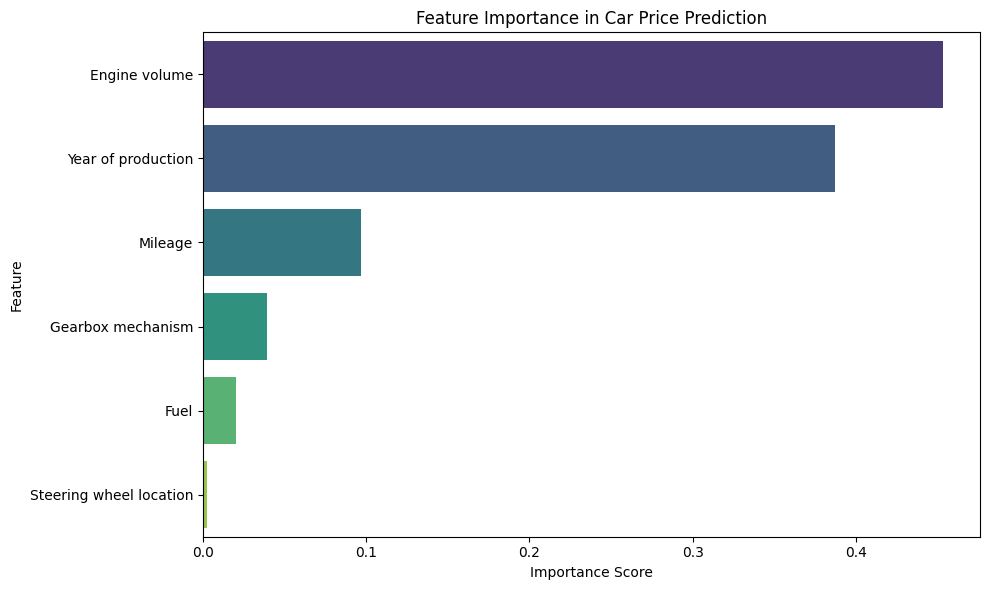

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature importances
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance in Car Price Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()